Modifying a Dataset
===================

In some cases, you may want to modify a dataset. For example, you may want to use a **different microphone geometry** or want a **different environment**. 
Let's say you want to use the **miniDSP UMA 16** channel microphone array, a popular MEMS microphone array. The geometric layout is available in the `Acoular` package.


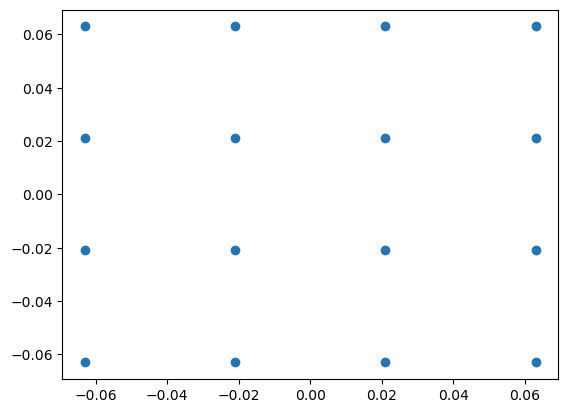

In [ ]:
import acoular
from pathlib import Path
import matplotlib.pyplot as plt

uma_file = Path(acoular.__file__).parent / 'xml' / 'minidsp_uma16.xml'
mg = acoular.MicGeom(file=uma_file)

plt.figure()
plt.scatter(mg.mpos[0], mg.mpos[1])
plt.show()


Changing the underlying dataset configuration
---------------------------------------------


Each dataset in the `acoupipe.datasets` module has its own default configuration object, which, after instantiation of the dataset class, is available as the `config` attribute.
The configuration object holds all necessary objects needed to generate the dataset. For example, the microphone geometry is stored in the `mics` attribute.

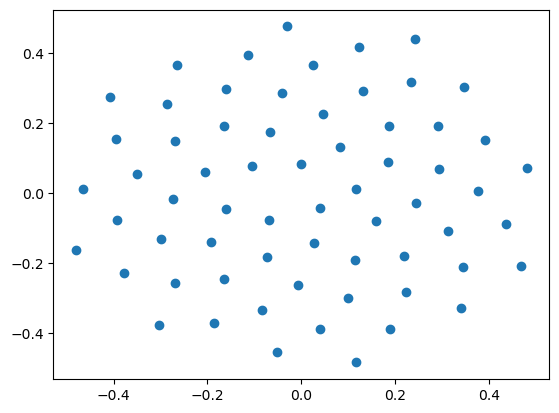

In [5]:
from acoupipe.datasets.synthetic import DatasetSynthetic

dataset = DatasetSynthetic()

plt.figure()
plt.scatter(
    dataset.config.mics.mpos[0], 
    dataset.config.mics.mpos[1]) 
plt.show()


Theoretically, one could change the microphone geometry by directly modifying the `mics` attribute. However, this is not recommended, as the configuration object is not aware of the change. 
A better way is to subclass a new configuration object and to overwrite the method responsible for creating the microphone geometry. In this case, the method is called `create_mics`. 
 We could also change the speed of sound by changing the environment created in the `create_env` method.
Both methods are called during the instantiation of the dataset, so we need to overwrite it before we create the dataset. 

In [ ]:

from acoupipe.datasets.synthetic import DatasetSyntheticConfig

class ConfigUMA(DatasetSyntheticConfig):
    
    def create_mics(self):
        uma_file = Path(acoular.__file__).parent / 'xml' / 'minidsp_uma16.xml'
        return acoular.MicGeom(file=uma_file)

    def create_env(self):
        return acoular.Environment(c=345.0)




With the new configuration object, we can create a new dataset that uses the UMA 16 microphone array.


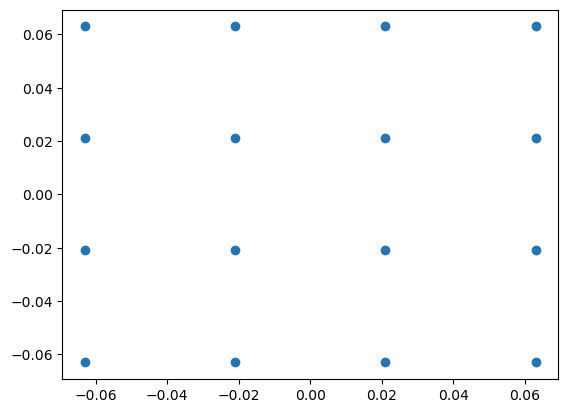

In [8]:
config = ConfigUMA()
dataset_uma = DatasetSynthetic(config=config)

plt.figure()
plt.scatter(
    dataset_uma.config.mics.mpos[0], 
    dataset_uma.config.mics.mpos[1])
plt.show()


It's worth noting that the grid has changed as well, as it is scaled by the microphone geometries aperture size (see the `create_grid` method for details).

Now one can extract the data from the dataset as usual, e.g., the source mapping.


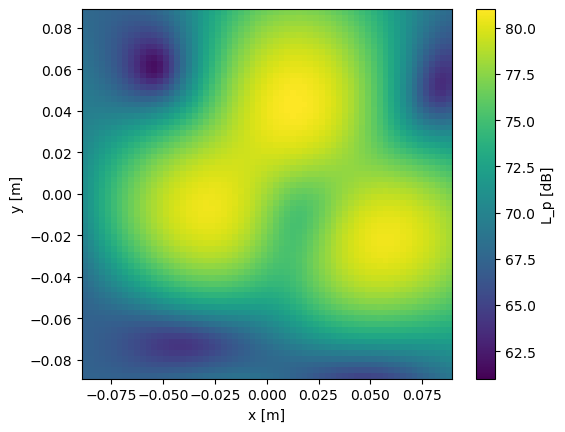

In [13]:

data_generator = dataset_uma.generate(
    split='training', features=['sourcemap'], 
    f=4000, size=1000, progress_bar=False)

data = next(data_generator)

Lm = acoular.L_p(data['sourcemap'].T) # convert to dB

plt.figure()
plt.imshow(Lm, origin='lower', extent=dataset_uma.config.grid.extend(),
            cmap='viridis', vmin=Lm.max() - 20, vmax=Lm.max())
plt.colorbar(label='L_p [dB]')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()